<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%208/Leçon_8_Demo_Debruitage_Compression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# ELE8812 - Compression

## Démo: Débruitage et compression par transformée en ondelettes rapide

### Référence : DIP 4e édition, Chapitre 8, « Wavelet Coding » p.614

Dans ce démo, une transformée en ondelettes discrète d’une image sera effectuée. Une partie des coefficients les plus faibles sera mise à zéro en fonction d’un seuil choisi. Cette approche peut être utilisée pour débruiter et/ou compresser une image.


In [35]:
import imageio
import numpy as np
import pywt
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [36]:
# Parameters
plt.rcParams['axes.linewidth'] = 3
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
thresholdTypes = ['hard', 'soft']
thresholdValues = widgets.FloatSlider(0.05, min=0.0, max=1.0, step=0.01, description='Threshold Value', continuous_update=False)
displayTypes = ['decomposition', 'details_histogram', 'thresholded_decomposition', 'denoised_image', 'composite']
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3','sym4','sym5','sym6']

In [ ]:
!git clone https://github.com/evaalonsoortiz/ELE8812-demos.git Repo

## Image à débruiter/compresser

L’image utilisée dans le démo peut être sélectionnée parmi un choix de 5 images. Les images CT – Crâne et IRM – Genou sont particulièrement affectées par le bruit.

In [38]:
imageSelector = widgets.Dropdown(options={'Vase': 'Repo/Data/Vase.tif', 'Lenna': 'Repo/Data/Lenna.tif',
                                          'IRM - Genou': 'Repo/Data/IRMgenou.tif', 'CT - Thorax': 'Repo/Data/CTthorax.tif',
                                          'CT - Crâne': 'Repo/Data/CTcrane.tif'}, value='Repo/Data/IRMgenou.tif', description='Image:')

In [39]:
imageSelector

Dropdown(description='Image:', index=2, options={'Vase': 'Repo/Data/Vase.tif', 'Lenna': 'Repo/Data/Lenna.tif',…

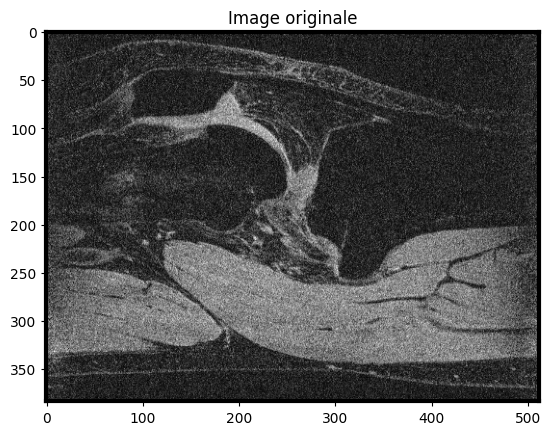

In [40]:
img = imageio.v2.imread(imageSelector.value)
img = (img - img.min()) / (img.max() - img.min()) # Normalisation entre 0 et 1
plt.imshow(img, cmap = 'gray');plt.title('Image originale'); plt.show()

## Types de seuillage

2 types de seuillage peuvent être effectués. Avec le seuillage dur, les coefficients plus faibles que +T et plus élevés que -T sont mis à zéro. Les autres coefficient demeurent inchangés. Avec le seuillage doux, les coefficients plus faibles que +T et plus élevés que -T sont également mis à zéro mais les autres coefficient sont aussi modifiés (voir définition ci-dessous).

### Seuil dur
\begin{equation}
I = \left\{ \begin{matrix} I & \text{si }I \geq I_{seuil}\\ 0 & \text{sinon}\end{matrix} \right.
\end{equation}

### Seuil doux
\begin{equation}
I = \left\{ \begin{matrix} I - I_{seuil} & \text{si }I \geq I_{seuil}\\ I + I_{seuil} & \text{si } I \leq -I_{seuil} \\ 0 & \text{sinon}\end{matrix} \right.
\end{equation}

In [41]:
def display_thresholdTypes(thresh = 0.25):
    x = np.linspace(-1,1,512)
    y = x * 1.0
    y_ht = np.copy(y)
    y_ht[np.abs(y)<thresh] = 0.0
    y_st = np.copy(y)
    y_st[np.abs(y)<thresh] = 0.0
    y_st[y<=-thresh] = y_st[y<=-thresh] + thresh
    y_st[y>=thresh] = y_st[y>=thresh] - thresh

    plt.figure(figsize=(15,5))
    plt.subplot(121); plt.plot(x, y_ht)
    plt.grid(True)
    plt.axvline(thresh, color='red', alpha=0.75); plt.axvline(-thresh, color='red', alpha=0.75)
    plt.xlabel('Value before thresholding')
    plt.ylabel('Value after thresholding')
    plt.ylim([-1,1])
    plt.title('Hard Thresholding (T=0.25)')

    plt.subplot(122); plt.plot(x, y_st)
    plt.grid(True)
    plt.axvline(thresh, color='red', alpha=0.75); plt.axvline(-thresh, color='red', alpha=0.75)
    plt.xlabel('Value before thresholding')
    plt.ylim([-1,1])
    plt.title('Soft Thresholding (T=0.25)')
    plt.tight_layout()
    plt.show()

In [42]:
interactive(display_thresholdTypes, thresh=(0,1,0.05))

interactive(children=(FloatSlider(value=0.25, description='thresh', max=1.0, step=0.05), Output()), _dom_class…

# Débruitage et compression de l'image

In [43]:
# Décomposition en ondelettes
def wavelet_decomposition_denoising(img, wavelet='haar', nLevels=1, thresholdType='hard', thresholdValue=0.05, displayType='decomposition', displayCompressionRate=False):
    coeffs = pywt.wavedec2(img, wavelet, level=nLevels)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    arr_p = np.copy(arr)
    arr_p[np.abs(arr) < thresholdValue] = 0.0
    if thresholdType == 'soft':
        arr_p[arr >= thresholdValue] -= thresholdValue
        arr_p[arr <= -thresholdValue] += thresholdValue
    arr_p[coeff_slices[0]] = arr[coeff_slices[0]]

    coeffs_p = pywt.array_to_coeffs(arr_p, coeff_slices, output_format='wavedec2')
    img_p = pywt.waverec2(coeffs_p, wavelet)
    plt.figure(figsize=(20,8))

    if displayCompressionRate:
        plt.figure(figsize=(20,5))
        details_mask = np.ones_like(arr, dtype=bool)
        details_mask[coeff_slices[0]] = False
        compression_rate = np.sum(arr_p[details_mask] == 0) / arr_p.size
        error_rate = np.sqrt(np.sum((img - img_p)**2) / np.sum(img**2))
        print("Compression rate: {:.2f}%".format(compression_rate * 100))
        print("Error (RMS): {:.2f}%".format(error_rate * 100))
    if displayType == 'decomposition':
        plt.imshow(arr, cmap = 'gray'); plt.show()
    elif displayType == 'details_histogram':
        details_mask = np.ones_like(arr, dtype=bool)
        details_mask[coeff_slices[0]] = False
        plt.hist(arr[details_mask].ravel(), 64, log=True);plt.xlabel('Coefficient value'); plt.show()
    elif displayType == 'thresholded_decomposition':
        plt.imshow(arr_p, cmap = 'gray'); plt.show()
    elif displayType == 'denoised_image':
        plt.imshow(img_p, cmap = 'gray'); plt.show()
    elif displayType == 'composite':
        plt.figure(figsize=(16,5))
        plt.subplot(131); plt.imshow(img, cmap = 'gray'); plt.title('Originale')
        plt.subplot(132); plt.imshow(img_p, cmap = 'gray'); plt.title(u'Débruitée / Compressée')
        plt.subplot(133); plt.imshow(img - img_p, cmap = 'gray'); plt.colorbar(shrink = 0.5); plt.title(u'Différence')
        plt.show()

Dans la visualisation suivante, le type d’ondelette ainsi que le nombre de niveaux d’échelle peuvent être modifiés. 5 visualisation différentes  (*display type*) sont possibles :

1. Decomposition : Transformée en ondelette discrète.
2. Details histogram : L’histogramme des coefficients de la transformée (avant le seuillage).
3. Thresholded decomposition : Transformée en ondelette discrète après le seuillage.
4. Denoised image : Image obtenue après la mise à zéro des coefficients et la transformée en ondelette inverse.
5. Composite : Image originale, image reconstruite et différence entre les 2 images.

Le taux de compression et l’erreur RMS entre l’image originale et l’image reconstruite peuvent aussi être affichés en cochant la case `displayCompressionRate`.
Lorsque le seuil augmente, un plus grand nombre de coefficients est mis à zéro. Ceci augmente le taux de compression ainsi que l’erreur RMS.



In [44]:
interactive(wavelet_decomposition_denoising, img = fixed(img), wavelet=waveletList, nLevels=(1,6),
            thresholdType=thresholdTypes, thresholdValue=thresholdValues, displayType=displayTypes)

interactive(children=(Dropdown(description='wavelet', options=('haar', 'db2', 'db3', 'db4', 'sym2', 'sym3', 's…